In [4]:
import xarray as xa
from cmocean import cm
import pylab as pl
import importlib
from scipy import signal
import numpy as np
import pandas as pd
from os.path import join
import ice_conc_algo as ia
importlib.reload(ia)

<module 'ice_conc_algo' from '/home/jol/Documents/code/ice_conc_predict/development/compare_algos/ice_conc_algo.py'>

In [5]:
HEMISPHERE = 'nh'
direc = '/mnt/isilon/home/jol/ice_conc/amsr2/gridded_brightness_temperatures/'
fname = 'brightness_temperatures_{0}_polstere-100_amsr2_*.nc'.format(HEMISPHERE)
full_path = join(direc, fname)
ds = xa.open_mfdataset(full_path)

/data/opt/anaconda3/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/data/opt/anaconda3/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


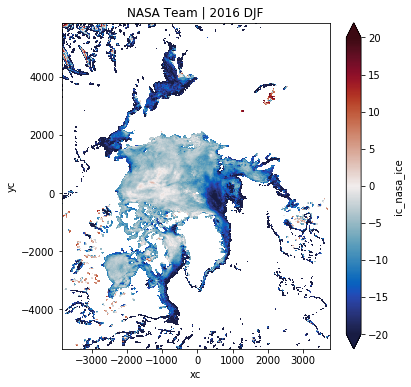

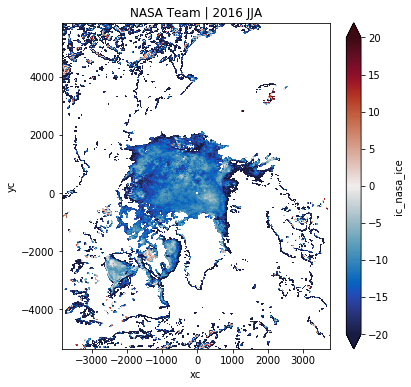

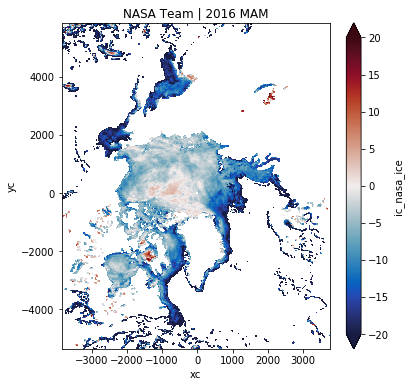

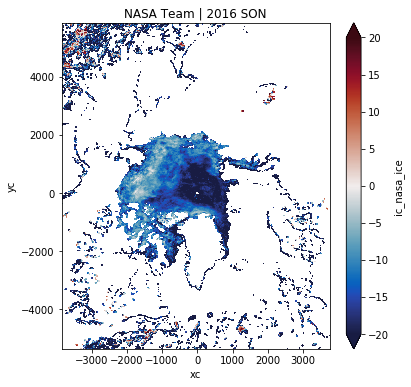

In [9]:
ICE_THRESHOLD = 0.75 # Where scale is between 0 and 1. Under this values is masked out. 
is_land = (ds['status_flag'] == 100).isel(time=0)
ic_nasa = ia.nasa(ds['tb19v'], ds['tb19h'], ds['tb37v'])
ic_nasa_ice = 100*ic_nasa.where(~is_land & (ic_nasa > ICE_THRESHOLD))
ds['ic_nasa_ice'] = ic_nasa_ice

# Group by generators

# Put Decemeber in the following year, as we want to look at consecutive months
dates = pd.DatetimeIndex(ds.time.to_series())
season_years = dates.year
season_years.where(dates.month == 12, dates.year + 1)
ds['season_years'] = season_years

def ice_by_season():
    "Return dasasets for each season"
    for year, dsyears in ds.groupby('season_years'):
        for season, dsyearsmonths in dsyears.groupby('time.season'):
            yield year, season, dsyearsmonths['ic_nasa_ice']

def ice_by_month():
    "Return dataset for each month"
    for year, dsyear in ds.groupby('time.year'):
        for month, dsmonth in dsyear.groupby('time.month'):
            yield year, month, dsmonth['ic_nasa_ice'] 

# -------------------  
            
def mean_ds(ice):
    return (ice - 100).mean(dim='time')
            
def anomoly_plot(ice):
    ice.plot(vmin=-20, vmax=20, cmap=cm.balance, figsize=(6,6))
    pl.title('NASA Team | {0} {1}'.format(year, season))
    pl.show()
    
# Select how to group
ice_by = ice_by_season()
# ice_by = ice_by_month()

for year, season, ice_ds in ice_by:
    ice_mean = mean_ds(ice_ds)
    anomoly_plot(ice_mean)

In [64]:
is_near_land = signal.convolve2d(is_land, np.ones((10,10)))
ic_nasa_ice = ic_nasa.where(is_near_land).isel(time=10)